In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from skimage import io, transform

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Dataset creation

In [2]:
subset = 'train'
resized = 'resized2'

folder = ".."+os.sep+"data"+os.sep
file =  subset + os.sep + subset + ".csv"
image_path = ".."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep

#Create mapping for labels
df = pd.read_csv(folder + file)
classes = df.classid.unique()
classes.sort()
classes_map = { classes[i]:i for i in range(len(classes)) }

In [3]:
# Plot image for testing
def show_image(image, label):
    plt.imshow(image)
    plt.title(label)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [4]:
#Défénition d"une class abstraite de pytorch

# Dataset Class
class PlantsDataset(Dataset):
    """Plants dataset."""

    def __init__(self, csv_file, root_dir, classes, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform #Pytorch ne traite pas les même vecteurs d'images, nous y appliquons une transformation
        self.classes_map = classes #Les classes des plante (attention il faut convertir le numéro des classe entre 1 et 50 pour les rendre continue)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                str(self.df.iloc[idx, 1]))
        image = io.imread(img_name + '.jpg')
        label = self.df.iloc[idx, 4]
        sample = {'image': image, 'label': classes_map[label]}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

0 (150, 150, 3) 17


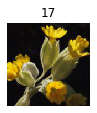

1 (150, 150, 3) 45


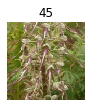

2 (150, 150, 3) 35


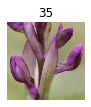

3 (150, 150, 3) 24


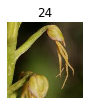

In [7]:
# Just testing if my dataset works
plants_dataset = PlantsDataset(csv_file=folder + file,
                                    root_dir=image_path, classes=classes_map)

fig = plt.figure()

for i in range(len(plants_dataset)):
    sample = plants_dataset[i]
    print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_image(**sample)

    if i == 3:
        plt.show()
        break

### Neural Network initialisation


In [8]:
resized = 'resized2'
folder = ".."+os.sep+"data"+os.sep

#Transformation dans un Tensor (comme une liste) et les valeur de chaque pixel (de 0 à 255) sont converti de 0 à 1
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#note : pour ne pas faire la decente de gradient par apport à la moyenne des tesst sur toute les image, nous entrainons sur des mini batch de 4 images

#Training Data
subset = 'train'
file =  subset + os.sep + subset + ".csv"
image_path = ".."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
trainset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

#Test Data
subset = 'test'
file =  subset + os.sep + subset + ".csv"
image_path = ".."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
testset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=0)

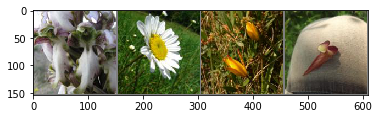

   25    10    43    37


In [9]:
# Show 4 random images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
batch = dataiter.next()
images, labels = batch['image'], batch['label']

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].data.numpy() for j in range(4)))

In [11]:
#le coeur du procéssus, l'architecture.
# Neural Network Architecture
class Net(nn.Module):
    #Dans un premier temps nous initialisons les différente couche
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5) #Appliquer un filtre à une image de 3 dimention pour la transformer en 8 dimention avec un filtre de taille 5*5
        self.pool = nn.MaxPool2d(2, 2)  #Prend des carré de pixel de taille 2*2 et les réduit à un seul pixel (diminue de deux la taille d'une image)
        self.conv2 = nn.Conv2d(8, 25, 5) #Appliquer un filtre à une image de 8 dimention pour la transformer en 25 dimention avec un filtre de taille 5*5
        self.fc1 = nn.Linear(25 * 64 * 64, 640) #Input (nombre de neuronne 25*64*64) et 1 colonne de neuronne (nombre de neuronne 640)
        self.fc2 = nn.Linear(640, 256)
        self.fc3 = nn.Linear(256, 50) #à la dernière couche il faut obligatoirement 50 neuronne, 1 par classe

    #ordre de traitement des couche
    def forward(self, x):
        #print(x.size())
        x = self.pool(F.relu(self.conv1(x))) #Première convultion, on lui applique la fonction relu pour la normaliser pour on réduit la taille de l'image par 2
        #print(x.size())
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.size())
        x = x.view(-1, 25 * 64 * 64)
        #print(x.size())
        x = F.relu(self.fc1(x))
        #print(x.size())
        x = F.relu(self.fc2(x))
        #print(x.size())
        x = self.fc3(x)
        return x
    
net = Net()

In [12]:
# Optmization
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [15]:
# Use the GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
net.to(device)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 25, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28900, out_features=640, bias=True)
  (fc2): Linear(in_features=640, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=50, bias=True)
)

In [16]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'].to(device), data['label'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 3.910
[1,   200] loss: 3.904
[1,   300] loss: 3.896
[1,   400] loss: 3.866
[1,   500] loss: 3.823
[2,   100] loss: 3.660
[2,   200] loss: 3.565
[2,   300] loss: 3.494
[2,   400] loss: 3.448
[2,   500] loss: 3.413
[3,   100] loss: 3.310
[3,   200] loss: 3.125
[3,   300] loss: 3.020
[3,   400] loss: 2.961
[3,   500] loss: 2.864
[4,   100] loss: 2.712
[4,   200] loss: 2.701
[4,   300] loss: 2.624
[4,   400] loss: 2.701
[4,   500] loss: 2.560
[5,   100] loss: 2.330
[5,   200] loss: 2.330
[5,   300] loss: 2.221
[5,   400] loss: 2.287
[5,   500] loss: 2.149
[6,   100] loss: 1.832
[6,   200] loss: 2.068
[6,   300] loss: 1.909
[6,   400] loss: 2.002
[6,   500] loss: 1.913
[7,   100] loss: 1.457
[7,   200] loss: 1.544
[7,   300] loss: 1.721
[7,   400] loss: 1.701
[7,   500] loss: 1.771
[8,   100] loss: 1.012
[8,   200] loss: 1.401
[8,   300] loss: 1.252
[8,   400] loss: 1.320
[8,   500] loss: 1.320
[9,   100] loss: 0.815
[9,   200] loss: 0.843
[9,   300] loss: 1.049
[9,   400] 

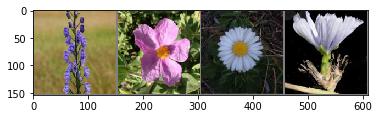

GroundTruth:  tensor(39) tensor(12) tensor(2) tensor(6)


In [19]:
dataiter = iter(testloader)
batch = dataiter.next()
images, labels = batch['image'], batch['label']

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(4)))

In [18]:
outputs = net(images.to(device))

In [14]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % predicted[j] for j in range(4)))

Predicted:  tensor(30, device='cuda:0') tensor(13, device='cuda:0') tensor(10, device='cuda:0') tensor(8, device='cuda:0')


In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data['image'].to(device), data['label'].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 695 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 695 test images: 31 %
